In [104]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlrd
import geopandas as gpd

In [239]:
RESOURCE_MAX = .25
INDICATORS = {
    'overall':{
        'crit':{
            'antimony':  {'vmax':RESOURCE_MAX},
            'beryllium': {'vmax':RESOURCE_MAX},
            'bismuth':   {'vmax':RESOURCE_MAX},
            'cadmium':   {'vmax':RESOURCE_MAX},
            'chromium':  {'vmax':RESOURCE_MAX},
            'cobalt':    {'vmax':RESOURCE_MAX},
            'graphite':  {'vmax':RESOURCE_MAX},
            'lithium':   {'vmax':RESOURCE_MAX},
            'magnesium': {'vmax':RESOURCE_MAX},
            'manganese': {'vmax':RESOURCE_MAX},
            'molybdenum':{'vmax':RESOURCE_MAX},
            'niobium':   {'vmax':RESOURCE_MAX},
            'palladium': {'vmax':RESOURCE_MAX},
            'platinum':  {'vmax':RESOURCE_MAX},
            'ree':       {'vmax':RESOURCE_MAX},
            'rhodium':   {'vmax':RESOURCE_MAX},
            'titanium':  {'vmax':RESOURCE_MAX},
            'tungsten':  {'vmax':RESOURCE_MAX},
            'uranium':   {'vmax':RESOURCE_MAX},
            'zirconium': {'vmax':RESOURCE_MAX},
        },
        'metals':{
            'aluminum':  {'vmax':RESOURCE_MAX},
            'copper':    {'vmax':RESOURCE_MAX},
            'gold':      {'vmax':RESOURCE_MAX},
            'silver':    {'vmax':RESOURCE_MAX},
            'nickel':    {'vmax':RESOURCE_MAX},
            'zinc':      {'vmax':RESOURCE_MAX},
            'lead':      {'vmax':RESOURCE_MAX},
            'steel':     {'vmax':RESOURCE_MAX},
            'tin':       {'vmax':RESOURCE_MAX},
        },
        'ag':{
            'coffee':    {'vmax':RESOURCE_MAX},
            'maize':     {'vmax':RESOURCE_MAX},
            'milk':      {'vmax':RESOURCE_MAX},
            'palm':      {'vmax':RESOURCE_MAX},
            'pork':      {'vmax':RESOURCE_MAX},
            'poultry':   {'vmax':RESOURCE_MAX},
            'rice':      {'vmax':RESOURCE_MAX},
            'soy':       {'vmax':RESOURCE_MAX},
            'sugar':     {'vmax':RESOURCE_MAX},
            'wheat':     {'vmax':RESOURCE_MAX},
            'beef':      {'vmax':RESOURCE_MAX},
        },
        'energy':{
            'gas':       {'vmax':RESOURCE_MAX},
            'oil':       {'vmax':RESOURCE_MAX},
            'coal':      {'vmax':RESOURCE_MAX},
        },
        'mil_ex': {'log':True, 'winsor':2.5},
        'arms': {
             'arms_ex': {'vmax':.5},
             'arms_im': {'vmax':.2},
        },
        'unga': {},
        'aid': {'vmax':.10},
        'trade':{'log':True, 'winsor':2.5},
        'fdi':{'log':True, 'winsor':2.5},
        'students':{
            'student_in':{'log':True, 'winsor':2.5},
            'student_out':{'log':True, 'winsor':2.5},
        }
    }
}
def iterind(f, indicators=None, **kwargs):
    if indicators is None:
        indicators = INDICATORS
    for k,v in indicators.items():
        if (type(v) is dict and len(v) and not ('vmin' in v or 'vmax' in v or 'log' in v)):
            iterind(f, v, **kwargs)
        f(k, v, **kwargs)

In [ ]:
countries = pd.read_csv('countries.csv')
#shps = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
shps = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip')
shps.head()

In [199]:
#countries.set_index('iso_a3').drop('-99')

In [231]:
dat = pd.read_csv('all_ind.csv')
dat.set_index('iso', inplace=True)
dat.head()

,country,aluminum_us,aluminum_cn,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,...,aid_us,aid_cn,unga_us,unga_cn,arms_ex_us,arms_im_us,arms_ex_cn,arms_im_cn,mil_ex_us,mil_ex_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.064,0.001,0.23,0.82,0.47,0.0,0.00,0.0,0,0
ALB,Albania,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005,0.000,0.48,0.50,0.00,0.0,0.00,0.0,10,0
DZA,Algeria,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.17,0.81,0.01,0.0,0.18,0.0,4,0
AGO,Angola,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001,0.012,0.16,0.81,0.00,0.0,0.07,0.0,3,2
ARG,Argentina,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.002,0.30,0.76,0.60,0.0,0.00,0.0,3,0


In [200]:
#countries.set_index('name').loc[dat['country']]['iso_a3'].to_csv('iso.csv')
#countries[['name', 'iso_a3']][~countries['name'].isin(dat['country']) ]

In [240]:
def norm(seq, vmin=None, vmax=None, log=False, winsor=False):
    if log:
        seq = seq+1
    if not vmin:
        if winsor:
            vmin = np.nanpercentile(seq, winsor)
        else:
            vmin = np.min(seq)
    if not vmax:
        if winsor:
            vmax = np.nanpercentile(seq, 100-winsor)
        else:
            vmax = np.max(seq)
    if log:
        seq = np.log(seq)
        vmin = np.log(vmin)
        vmax = np.log(vmax)
    s = (seq - vmin)/(vmax - vmin)
    s = np.clip(s, 0, 1)
    return s

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


,country,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,cadmium_cn,chromium_us,...,fdi_us,fdi_cn,student_in_us,student_in_cn,student_out_us,student_out_cn,students_us,students_cn,overall_us,overall_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.836858,0.502576,0.000000,0.000000,0.000000,0.251288,0.000000,0.221223,0.181813
ALB,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.543604,0.000000,0.000000,0.000000,0.271802,0.000000,0.156616,0.073689
DZA,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.934476,0.362408,0.153585,0.000000,0.000000,0.181204,0.076792,0.128159,0.242224
AGO,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.941245,0.612731,0.339347,0.000000,0.000000,0.306366,0.169673,0.133998,0.310797
ARG,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.884737,0.958361,0.681205,0.000000,0.860049,0.464535,0.770627,0.232268,0.330417,0.247995


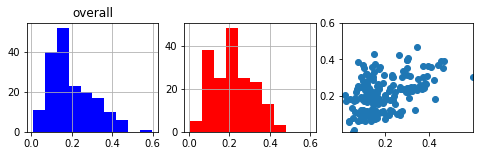

In [241]:
out = pd.DataFrame(index=dat.index)
out['country'] = countries.set_index('iso_a3').drop('-99')['name']
def agg(ind, args):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if args == {} or 'vmin' in args or 'vmax' in args or 'log' in args:
        if usi in dat:
            out[usi] = norm(dat[usi], **args)
            out.at['USA', usi] = np.nan
            if out[usi].min() == out[usi].max():
                out[usi] = np.nan
            out[cni] = norm(dat[cni], **args)
            out.at['CHN', cni] = np.nan
            if out[cni].min() == out[cni].max():
                out[cni] = np.nan
    else:
        usargs = ['{}_us'.format(arg) for arg in args]
        cnargs = ['{}_cn'.format(arg) for arg in args]
        out[usi] = np.nanmean(out[usargs], axis=1)
        out[cni] = np.nanmean(out[cnargs], axis=1)
iterind(agg)
plots('overall', dat=out)
out.head()

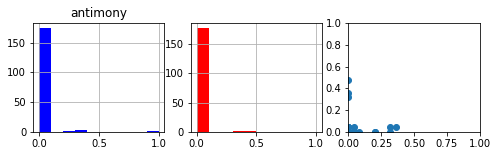

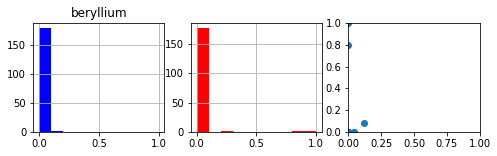

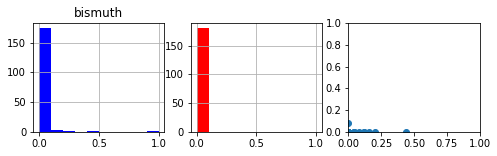

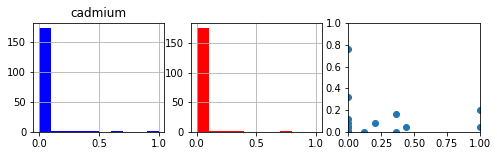

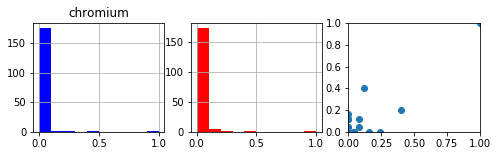

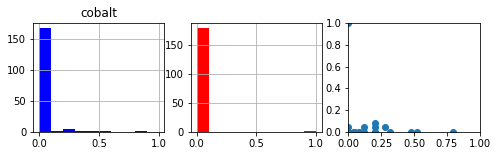

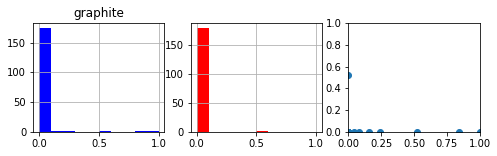

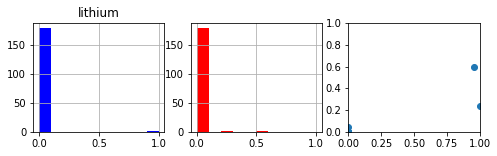

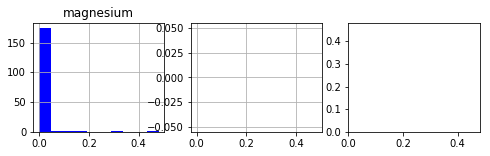

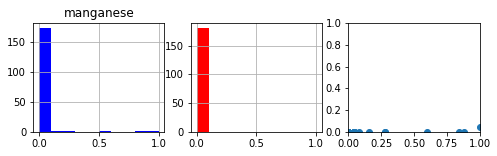

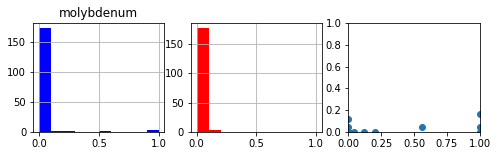

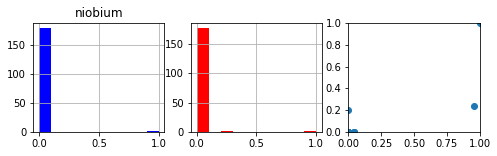

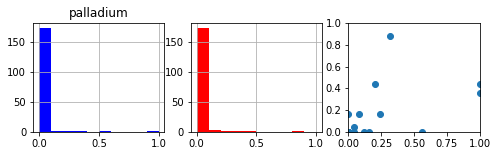

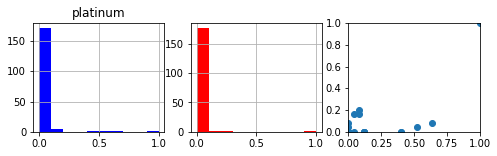

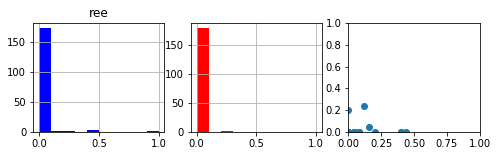

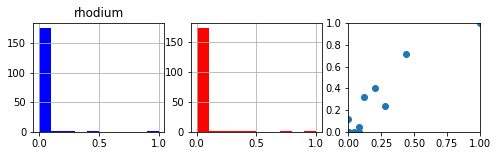

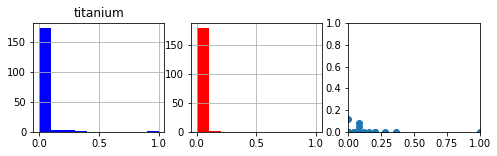

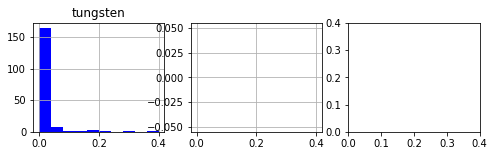

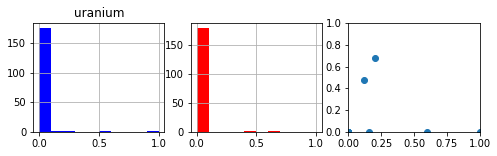

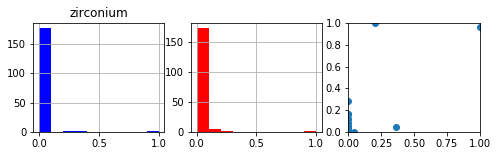

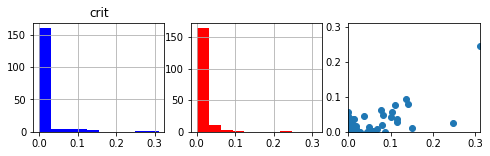

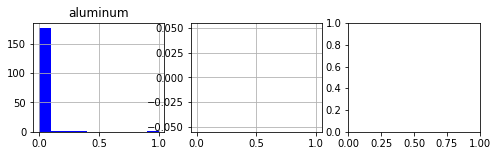

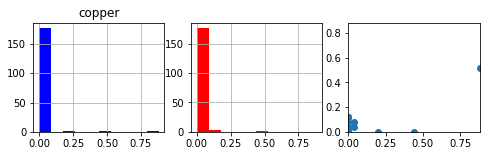

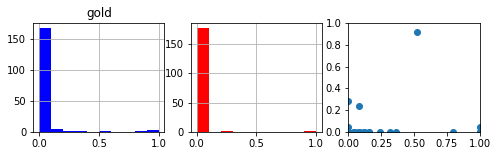

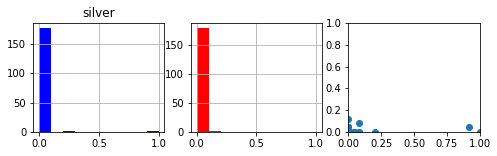

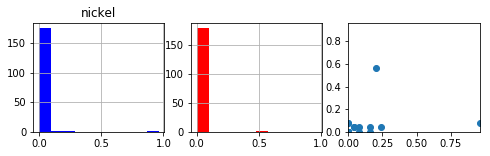

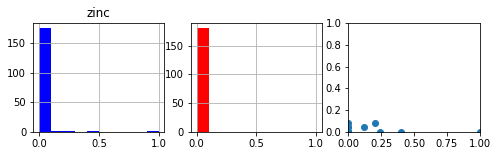

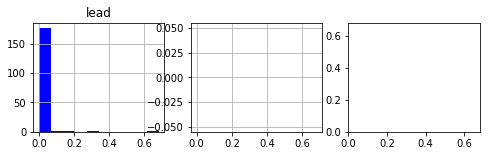

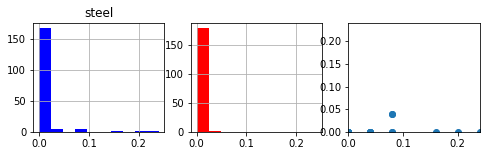

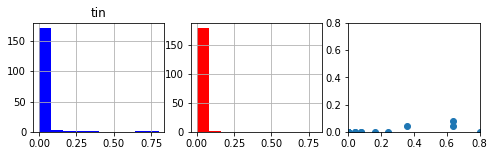

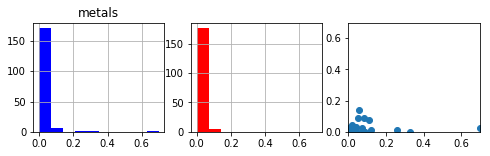

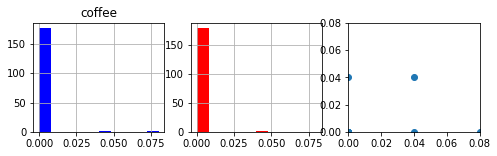

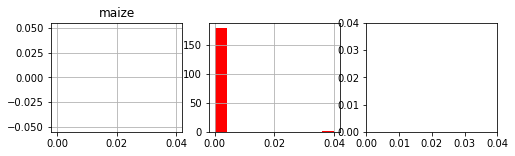

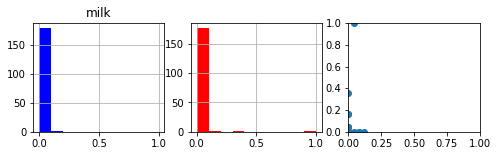

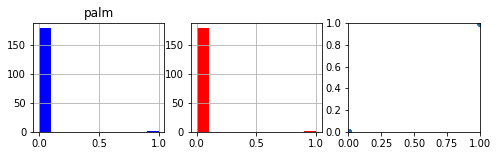

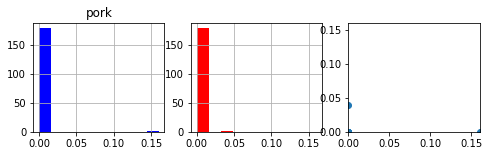

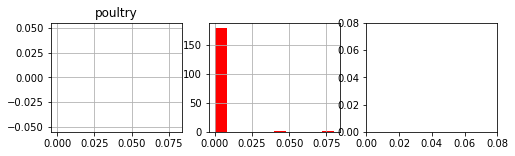

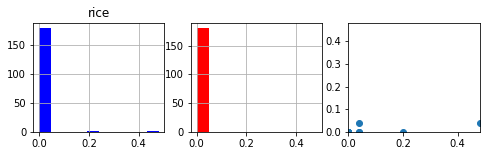

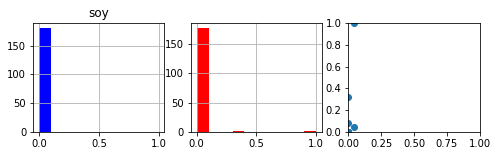

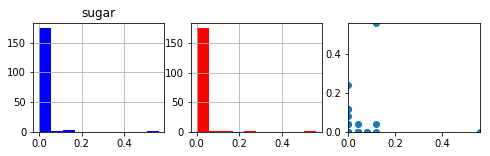

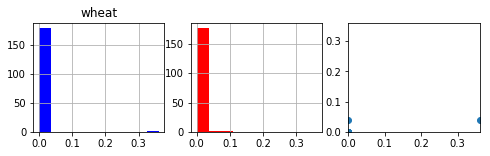

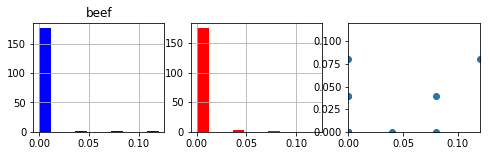

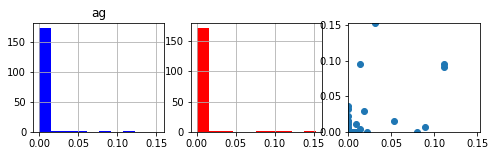

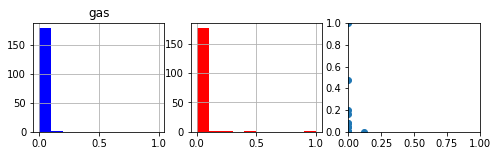

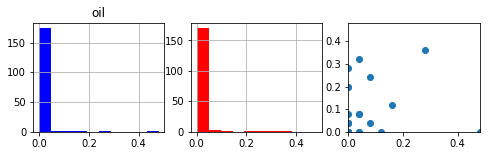

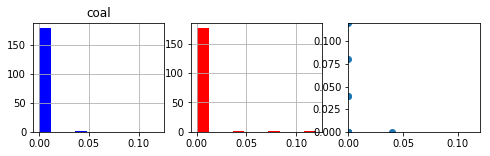

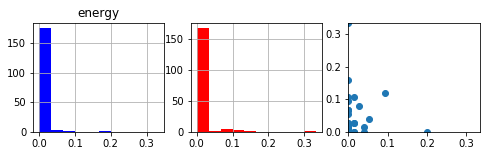

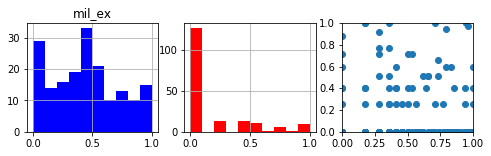

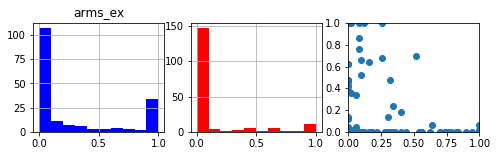

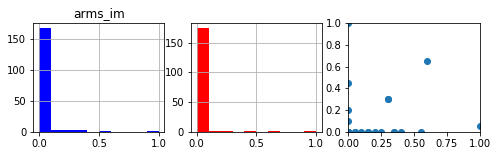

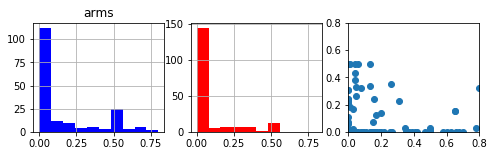

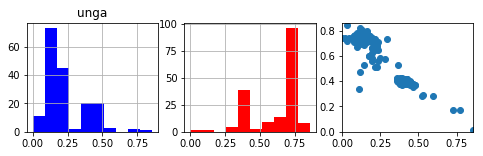

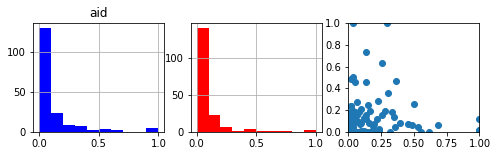

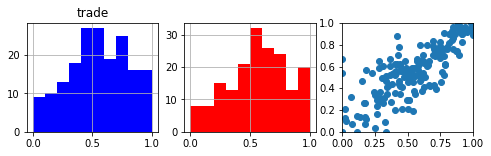

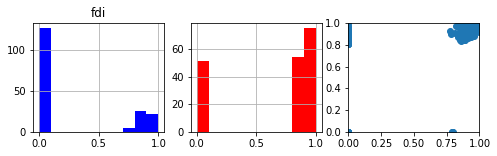

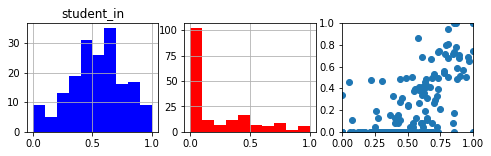

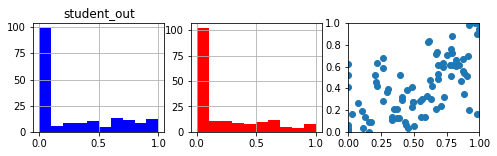

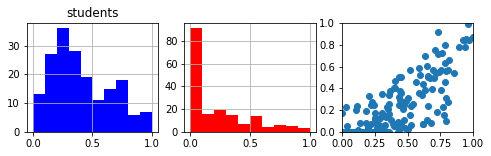

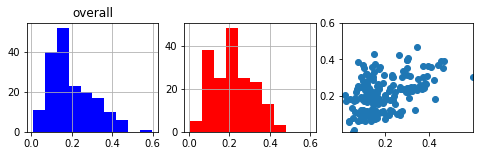

In [242]:
def plots(ind, *args, dat=dat):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        both = np.vstack((dat[usi], dat[cni]))
        minv = np.nanmin(both)
        maxv = np.nanmax(both)
        if minv == maxv:
            print(ind)
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        dat[usi].hist(ax=axs[0], color='b', range=(minv, maxv))
        dat[cni].hist(ax=axs[1], color='r', range=(minv, maxv))
        axs[2].scatter(dat[usi], dat[cni])
        axs[2].set_xlim((minv, maxv))
        axs[2].set_ylim((minv, maxv))
        axs[0].set_title(ind)
        fig.show()
iterind(plots, dat=out)

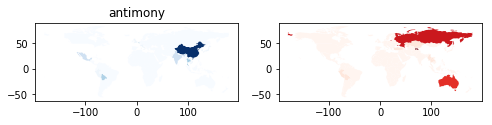

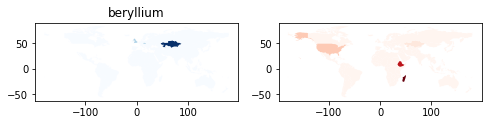

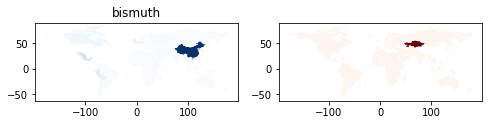

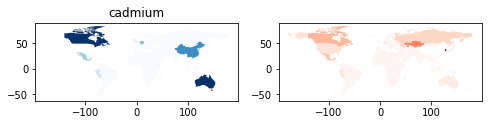

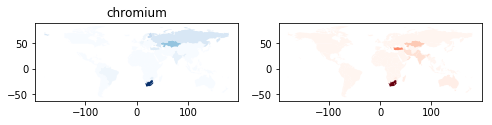

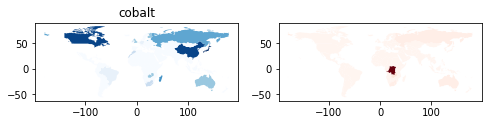

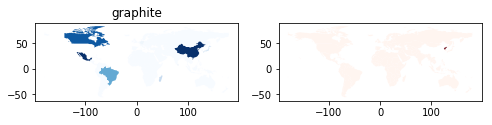

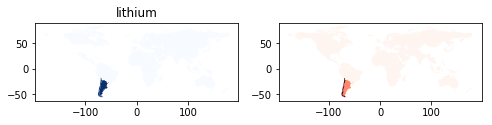

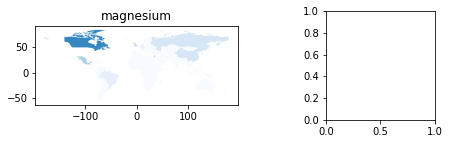

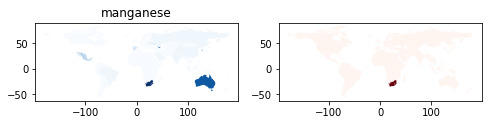

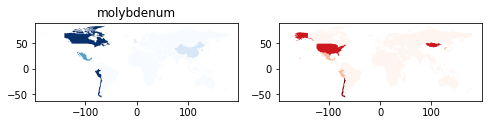

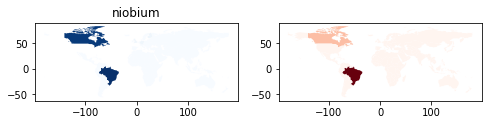

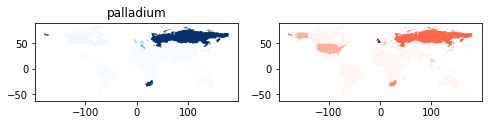

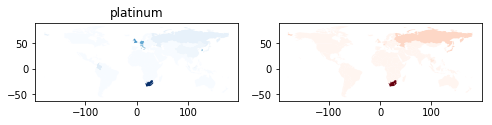

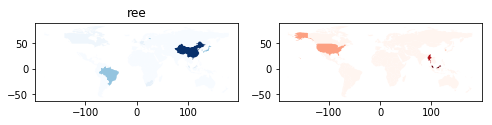

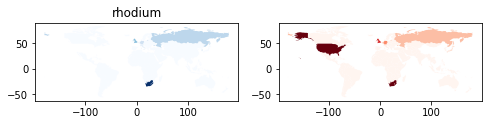

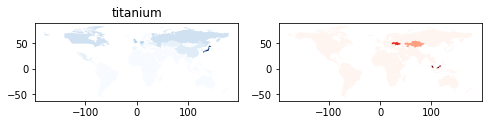

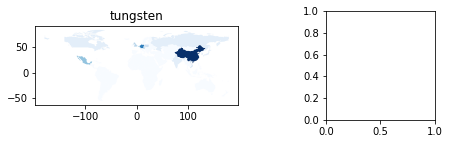

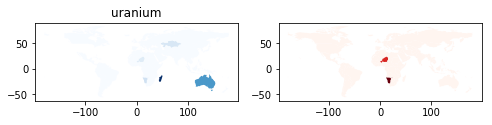

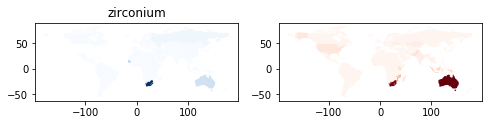

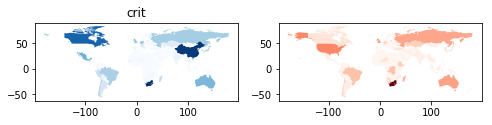

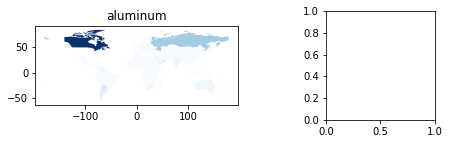

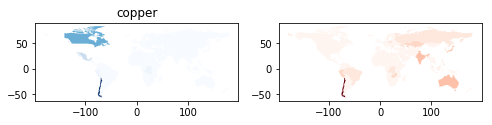

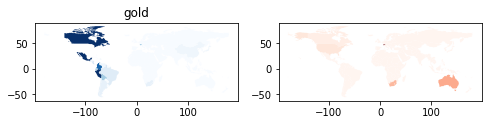

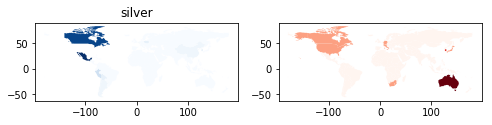

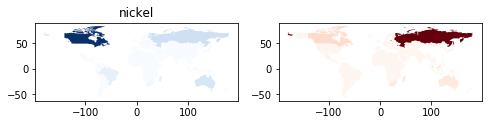

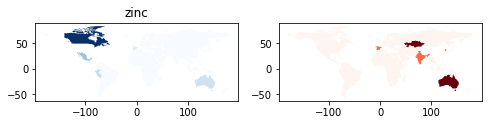

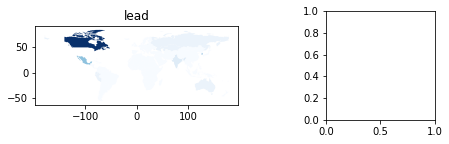

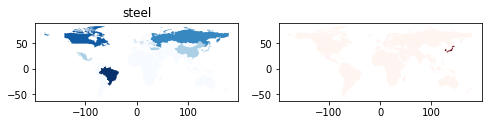

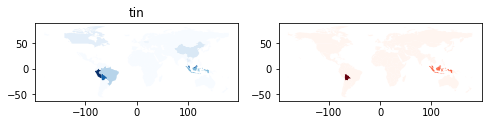

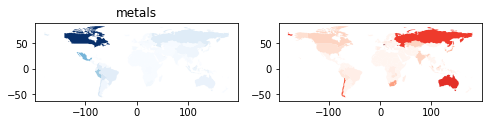

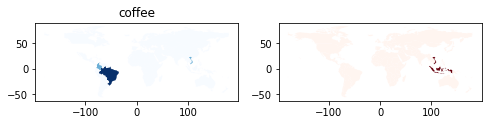

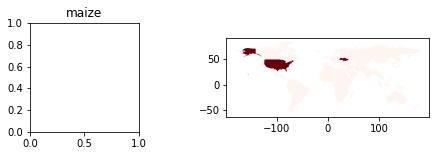

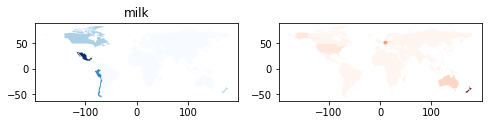

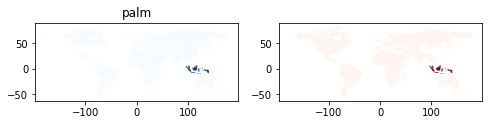

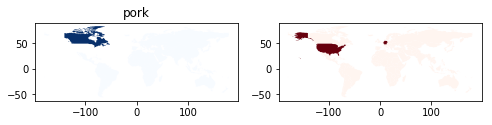

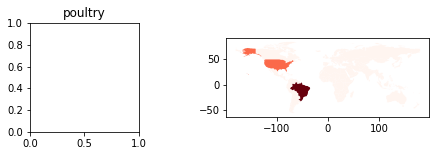

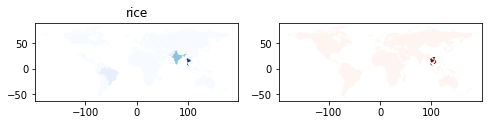

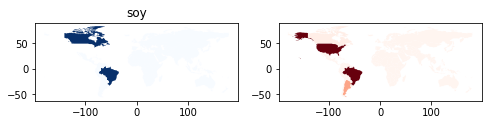

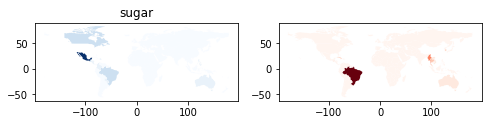

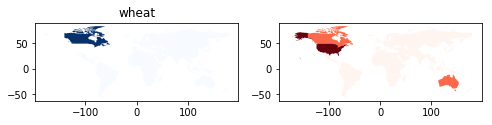

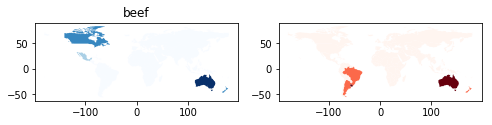

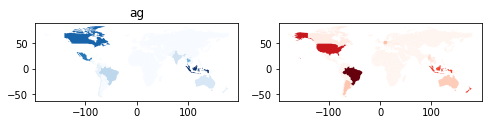

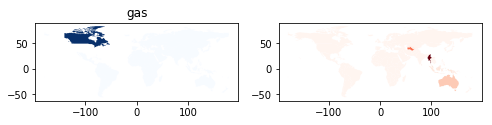

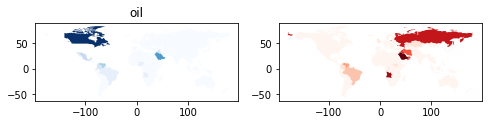

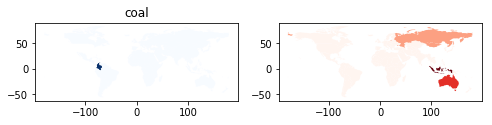

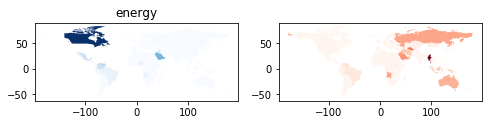

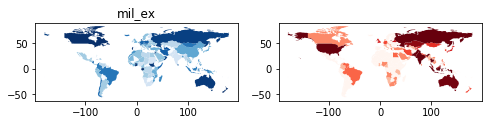

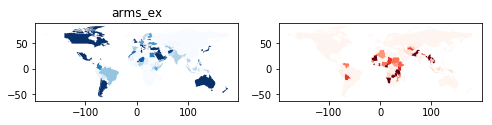

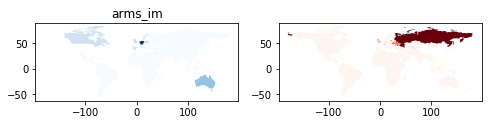

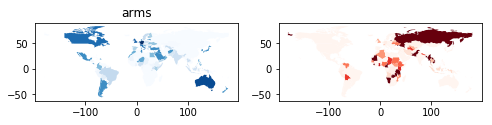

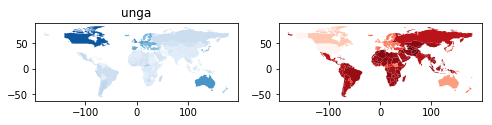

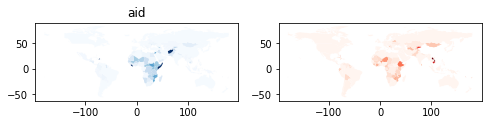

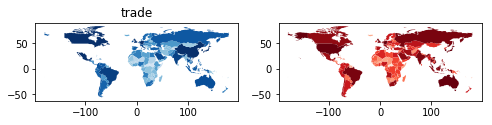

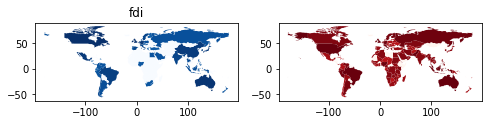

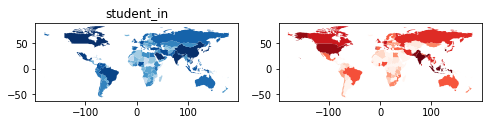

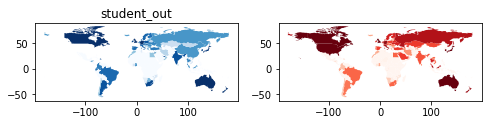

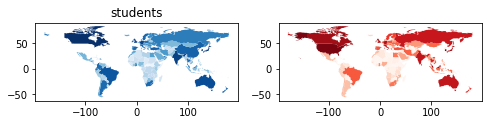

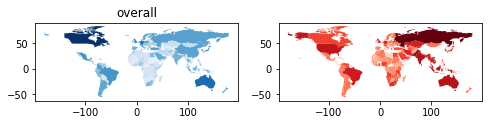

In [243]:
shp2 = shps.set_index('ISO_A3').join(out)
def maps(ind, *args, dat=dat):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        fig, axs = plt.subplots(1, 2, figsize=(8, 2))
        shp2[shp2[usi].notna()].plot(usi, ax=axs[0], cmap='Blues')
        shp2[shp2[cni].notna()].plot(cni, ax=axs[1], cmap='Reds')
        axs[0].set_title(ind)
        fig.show()
iterind(maps, dat=out)

In [244]:
def tops(ind, *args, dat=dat):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        print(ind)
        print(dat.set_index('country')[usi].sort_values(ascending=False).head())
        print(dat.set_index('country')[cni].sort_values(ascending=False).head())
        print('\n')
iterind(tops, dat=out)

antimony
country
China       1.00
Thailand    0.36
Belgium     0.32
Bolivia     0.32
India       0.20
Name: antimony_us, dtype: float64
country
Tajikistan    0.48
Russia        0.36
Australia     0.32
Laos          0.04
Turkey        0.04
Name: antimony_cn, dtype: float64


beryllium
country
Kazakhstan        0.12
Czech Republic    0.04
United Kingdom    0.04
Zimbabwe          0.00
Swaziland         0.00
Name: beryllium_us, dtype: float64
country
Madagascar                  1.00
Ethiopia                    0.80
United States of America    0.20
Kazakhstan                  0.08
Zimbabwe                    0.00
Name: beryllium_cn, dtype: float64


bismuth
country
China          1.00
Belgium        0.44
Mexico         0.20
South Korea    0.16
Peru           0.12
Name: bismuth_us, dtype: float64
country
Kazakhstan    0.08
Zimbabwe      0.00
Ethiopia      0.00
Greece        0.00
Ghana         0.00
Name: bismuth_cn, dtype: float64


cadmium
country
Canada       1.00
Australia    1.00
China   